In [1]:
import pickle
import numpy as np
from conviz_dev import *
%matplotlib inline
import matplotlib.pyplot as plt

pkl_file = open('params_epoch_10', 'rb')
params = pickle.load(pkl_file)

In [ ]:
params[4].shape

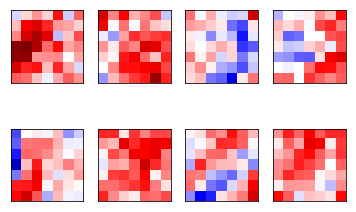

In [76]:
conviz.plot_conv_weights(params[2], 'Third Layer', channels_all=True)

In [ ]:
weights = params[0]
w_min = np.min(weights)
w_max = np.max(weights)
channels = range(weights.shape[0])
channels
num_filters = 4
grid_r, grid_c = utils.get_grid_dim(num_filters)
img = weights[0, 0, :, :]
plt.imshow(img)
plt.colorbar()

In [9]:
from theano import tensor as T
import lasagne as nn
import numpy as np
import pickle
from input_process import read_images
import random
import math
import cmath

size = (116, 116)
pkl_file = open('../fnames_collection_2', 'r')
fnames = pkl_file.readline()
fnames = fnames.split(' ')
for i in range (0,len(fnames)):
	fnames[i] = str(fnames[i])
	fnames[i] = 'image' + fnames[i] + '.png'

train_index = fnames[0:5]

label_path = '../NewPNGlabeled/'
ori_path = '../JpegOriginalImg/'
train_input, train_label = read_images(label_path, ori_path, train_index, size)

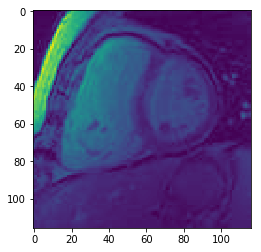

In [60]:
train_input.shape
img = train_input[3,0,:,:]
plt.imshow(img)

In [61]:
shape = [1,1,116,116]
layer = nn.layers.InputLayer(shape,train_input[3:4,:,:,:])
layer = nn.layers.Conv2DLayer(layer, num_filters = 4,filter_size = 7, W = params[0], b = params[1],
                              nonlinearity = nn.nonlinearities.rectify, pad = 'same') #116 
output = nn.layers.get_output(layer)
images = output.eval()


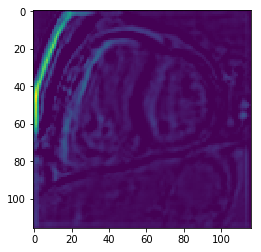

In [62]:
img_output = images[0,0,:,:]
plt.imshow(img_output)

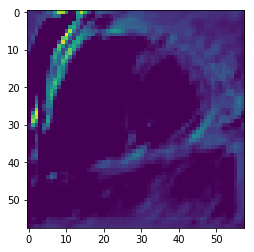

In [63]:
layer = nn.layers.MaxPool2DLayer(layer, pool_size = 2) 
layer = nn.layers.Conv2DLayer(layer, num_filters = 8,filter_size = 7, W = params[2], b = params[3],
                              nonlinearity = nn.nonlinearities.rectify, pad = 'same') #116 
output = nn.layers.get_output(layer)
images = output.eval()
img_output = images[0,0,:,:]
plt.imshow(img_output)

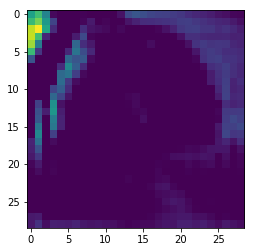

In [64]:
layer = nn.layers.MaxPool2DLayer(layer, pool_size = 2) 
layer = nn.layers.Conv2DLayer(layer, num_filters = 16,filter_size = 7, W = params[4], b = params[5],
                                  nonlinearity = nn.nonlinearities.rectify, pad = 'same') #52
output = nn.layers.get_output(layer)
images = output.eval()
img_output = images[0,0,:,:]
plt.imshow(img_output)

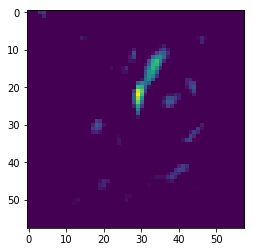

In [65]:
    # max pool layer
layer = nn.layers.Upscale2DLayer(layer, scale_factor = 2) 

layer = nn.layers.Conv2DLayer(layer, num_filters = 32,filter_size = 7, W = params[6], b = params[7],
                                  nonlinearity = nn.nonlinearities.rectify, pad = 'same') #52
output = nn.layers.get_output(layer)
images = output.eval()
img_output = images[0,0,:,:]
plt.imshow(img_output)

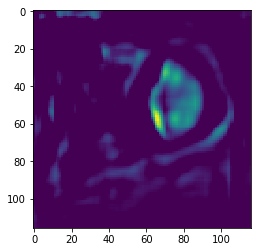

In [66]:
layer = nn.layers.Upscale2DLayer(layer, scale_factor = 2)  
layer = nn.layers.Conv2DLayer(layer, num_filters = 64,filter_size = 7, W = params[8], b = params[9],
                                  nonlinearity = nn.nonlinearities.rectify,pad = 'same') #52
output = nn.layers.get_output(layer)
images = output.eval()
img_output = images[0,0,:,:]
plt.imshow(img_output)

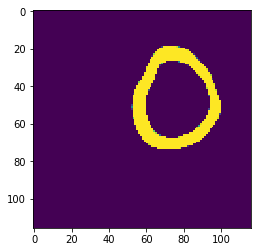

In [67]:
layer = nn.layers.Conv2DLayer(layer, num_filters = 1,filter_size = 7, W = params[10], b = params[11],
                                  nonlinearity = nn.nonlinearities.sigmoid, pad = 'same') #116 
output = nn.layers.get_output(layer)
images = output.eval()
img_output = images[0,0,:,:]
plt.imshow(img_output)               

(116, 116)

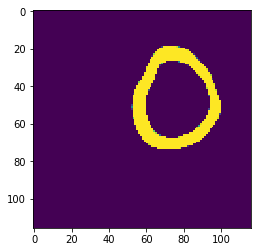

In [149]:
math.sqrt(2)

1.4142135623730951

In [263]:
def gabor_filter(x,y,params):
    f,gamma,sigma,theta,psi = params
    xt = x*np.cos(theta) + y*np.sin(theta)
    yt = -x*np.sin(theta) + y*np.cos(theta)
    z1 = -(xt**2 + (gamma*yt)**2)/(2*sigma**2)
    z2 = 2*math.pi*f*xt+psi
    value = f**2/(math.pi*gamma*math.sqrt(2))*np.exp(z1)*np.cos(z2)
    value = value.astype(np.float32)
    return value

def random_gabor(shape):
    [NumFilter, NumChannel] = shape
    gs = np.array([],dtype=np.float32).reshape(1,-1)
    
    for i in range (0,NumChannel*NumFilter):
        gamma = random.uniform(0,5)
        sigma = random.uniform(0,1.5)
        theta = random.uniform(0,2*math.pi)    
        psi = 0
        f = random.uniform(0,0.3)

        params = [f, gamma, sigma, theta, psi]
        
        g = np.array(params, dtype=np.float32).reshape(1,-1)
        gs = np.concatenate((gs,g),axis=1)
    gs = gs.reshape([NumFilter, NumChannel, 5])
    return gs  


def rescale(gfilter,mag):
    mi = np.min(gfilter)
    ma = np.max(gfilter)
    factor = 0.3/max([ma,-mi])
    return gfilter*factor


def gabor_filter_initiation(shape, gs):
    [num_filters,num_channels,size,size] = shape
    Ws = []
    gfilter = []

    for filter_index in range (0,num_filters):
        for channel_index in range (0,num_channels):
            
            params = gs[filter_index, channel_index]
            params = np.ndarray.tolist(params)
            
            bond = math.floor(size/2)
            x_range = np.linspace(-bond, bond, size)
            y_range = np.linspace(-bond, bond, size)

            xt,yt = np.meshgrid(x_range,y_range)
            a = gabor_filter(xt,yt,params).reshape(1,size,size)
            a = rescale(a,mag=0.3)
            if len(gfilter)==0:
                gfilter = a
            else:
                gfilter = np.concatenate((gfilter,a),axis=0)

        gfilter = gfilter.reshape(1,-1,size,size)
    
        if len(Ws)==0:
            Ws = gfilter 
        else:
            Ws = np.concatenate((Ws,gfilter),axis=0)
        gfilter = []
            
    return Ws

In [264]:
gs = random_gabor(np.array([4,4]))
weights = gabor_filter_initiation(np.array([4,4,7,7]), gs)
weights.shape

(4, 4, 7, 7)

[[ -4.33334615e-03   1.55388489e-02  -1.51150608e-02  -8.83146786e-05
    4.05242248e-03  -1.09190529e-03   7.99350964e-05]
 [  1.40309371e-02  -4.13464904e-02   1.94330439e-02   4.13716696e-02
   -3.57930698e-02   7.77279818e-03  -3.74031195e-04]
 [ -1.77743286e-02   3.62264290e-02   5.79347834e-02  -1.88183010e-01
    1.20437644e-01  -2.01598275e-02  -6.89689885e-04]
 [  8.36081989e-03   6.47244090e-03  -1.56796485e-01   2.99999982e-01
   -1.56796485e-01   6.47244090e-03   8.36081989e-03]
 [ -6.89689885e-04  -2.01598275e-02   1.20437644e-01  -1.88183010e-01
    5.79347834e-02   3.62264290e-02  -1.77743286e-02]
 [ -3.74031195e-04   7.77279818e-03  -3.57930698e-02   4.13716696e-02
    1.94330439e-02  -4.13464904e-02   1.40309371e-02]
 [  7.99350964e-05  -1.09190529e-03   4.05242248e-03  -8.83146786e-05
   -1.51150608e-02   1.55388489e-02  -4.33334615e-03]]


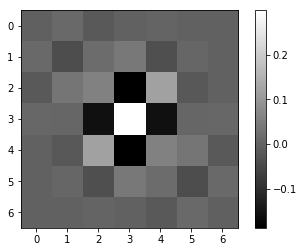

In [267]:
img = weights[0,3, :, :]
print(img)
plt.imshow(img,cmap='gray')
plt.colorbar()

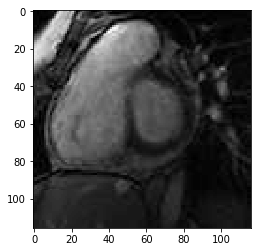

In [233]:
plt.imshow(img,cmap='gray')

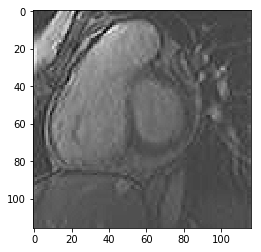

In [299]:
from scipy import ndimage
img = train_input[0,0,:,:]

def random_gabor():
    gamma = random.uniform(0,5)
    sigma = 1
    theta = 2*math.pi**1/2
    psi = 0.2
        #f = random.uniform(0,1.5)
    f = 0.3
    params = [f, gamma, sigma, theta, psi]
    return params  

size = 7
bond = math.floor(size/2)
x_range = np.linspace(-bond, bond, size)
y_range = np.linspace(-bond, bond, size)
xt,yt = np.meshgrid(x_range,y_range)
params = random_gabor()
a = gabor_filter(xt,yt,params).reshape(size,size)
a = rescale(a,mag=0.3)
img_after = ndimage.convolve(img, a, mode='constant', cval=0.0)
plt.imshow(img_after,cmap='gray')